In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from pathlib import Path

import sys
current_dir = Path.cwd()
repo_root = current_dir.parent.parent  # Go up 1 levels
pdpo_path = str(repo_root.absolute())
# Add repository root to path
sys.path.insert(0, pdpo_path)

print(sys.path)



['/work/Sebas/PDPO_jax', '/work/Sebas/miniconda3/envs/PDPO_jax/lib/python313.zip', '/work/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13', '/work/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/lib-dynload', '', '/work/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages']


In [2]:

import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from flax import nnx

# Import our interpolation functions
from pdpo.spline.interpolation import unstack_pytree, cubic_interp,linear_interpolation_states,linear_interp
from pdpo.models.builder import create_model

# Set random seeds for reproducibility
key = jrandom.PRNGKey(0)
np.random.seed(0)

print("JAX version:", jax.__version__)


JAX version: 0.7.0


# Test with trained networks

In [3]:
from pdpo.generative.models.matching_methods import FlowMatching,StochasticInterpolant
from pdpo.data.toy_datasets import inf_train_gen
from pdpo.ode.solvers import MidpointSolver,ODESolver,sample_trajectory
from pdpo.core.types import (
    ModelParams,
    ModelState,
    TimeArray,
    SampleArray,
    VelocityArray,
    ScoreArray,
    PRNGKeyArray
)

import pickle


In [4]:
name_exp0 = 'fm_std_gaussian_to_gaussian0_epoch_4999'
directory_file = pdpo_path+'/checkpoints/generative/'+name_exp0+'.pkl'
# Load the model parameters
with open(directory_file, 'rb') as f:
    model_params0 = pickle.load(f)

name_exp1 = 'fm_std_gaussian_to_gaussian1_final'
directory_file = pdpo_path+'/checkpoints/generative/'+name_exp1+'.pkl'
# Load the model parameters
with open(directory_file, 'rb') as f:
    model_params1 = pickle.load(f)    


# # args_arch = [2, 3, 4, 'softplus', True, jax_key]  # Example architecture args
args_arch = [model_params0['model_config']['input_dim'],
             model_params0['model_config']['num_layers'],
             model_params0['model_config']['hidden_dim'],
             model_params0['model_config']['activation'],
             model_params0['model_config']['time_varying'],
             key
            ]
key,subkey = jrandom.split(key)
print(args_arch)
# # Create MLP
vf = create_model(
    type='mlp',
    args_arch=args_arch
)

from pdpo.models.builder import create_mlp

key,subkey = jrandom.split(key)

vf = create_mlp(
    input_size= model_params0['model_config']['input_dim'],
    num_layers= model_params0['model_config']['num_layers'],
    layer_width= model_params0['model_config']['hidden_dim'],
    activation= model_params0['model_config']['activation'],
    time_varying=model_params0['model_config']['time_varying'],
    key=subkey
)

key,subkey = jrandom.split(key)

[2, 4, 128, 'softplus', True, Array([0, 0], dtype=uint32)]


In [5]:
state0 = model_params0['model_state']
state1 = model_params1['model_state']

bds = [state0, state1]

In [6]:
num_control_points = 7
t_controls = jnp.linspace(0,1,num_control_points)
s_query = jnp.linspace(0,1,30)


In [7]:
from pdpo.spline.builder import Assemble_spline

In [8]:
spline,t_controls = Assemble_spline(
    theta0 = state0,
    theta1 = state1,
    type_arch = 'mlp',
    arch = args_arch,
    data0= model_params0['data_config']['target_type'],
    data1= model_params1['data_config']['target_type'],
    number_of_knots= num_control_points,
    spline_type= 'linear',
    device= 'gpu:0',
    prior_dist= model_params0['data_config']['source_type'],
    p= 2
)

In [9]:
from pdpo.spline.dynamics import gen_sample_trajectory

In [10]:
theta0,theta1  = spline.boundary_params
control_parameters = spline.control_points

all_params = [theta0] + control_parameters + [theta1]

In [11]:
sample_trajectory = gen_sample_trajectory(
    spline_state=spline,
    vf=vf,
    key=subkey,
    num_samples=500,
    t_traj=s_query,
    solver=MidpointSolver,
)

key,subkey = jrandom.split(key)

/tmp/ipykernel_1201015/2965285322.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


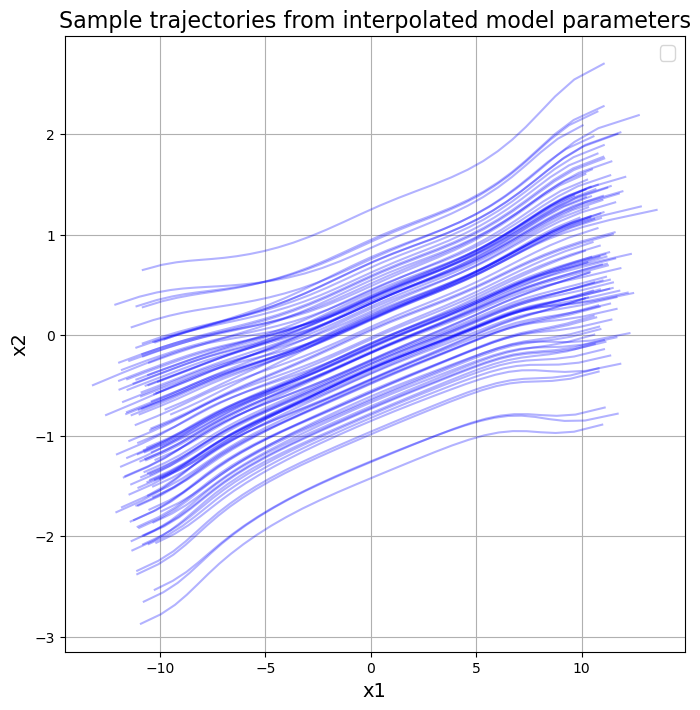

In [12]:
fig = plt.figure(figsize=(8, 8))    

for i in range(0,len(sample_trajectory),5):
    plt.plot(sample_trajectory[i,:,0],sample_trajectory[i,:,1],'b-',alpha=0.3)
plt.title('Sample trajectories from interpolated model parameters',fontsize=16)
plt.legend(fontsize=14)
plt.xlabel('x1',fontsize=14)
plt.ylabel('x2',fontsize=14)
plt.grid()
plt.show()

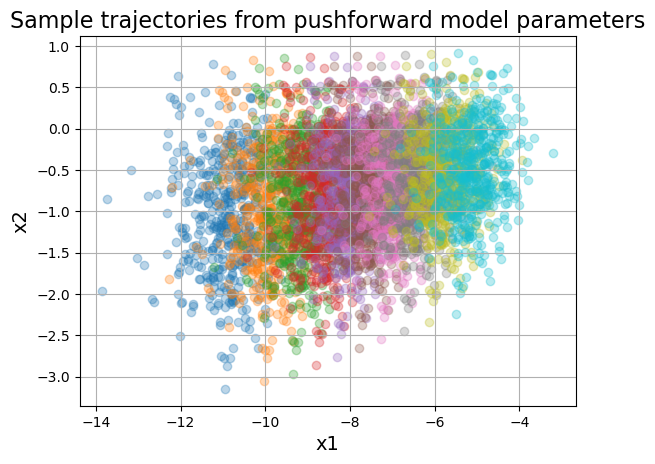

In [13]:
for i in range(10):
    plt.scatter(sample_trajectory[:,i,0],sample_trajectory[:,i,1],alpha=0.3)
plt.title('Sample trajectories from pushforward model parameters',fontsize=16)
plt.xlabel('x1',fontsize=14)
plt.ylabel('x2',fontsize=14)
plt.grid()
plt.show()

In [14]:
from pdpo.spline.energy import lagrangian

In [15]:
from pdpo.spline.types_interpolation import ProblemConfig

In [16]:
config_problem = ProblemConfig(
    splinestate=spline
)


In [17]:
lagrangian(
    samples_path=sample_trajectory,
    times_path= s_query,
    problem_config = config_problem
)

(Array(257.9944, dtype=float32),
 Array(257.9944, dtype=float32),
 Array(0., dtype=float32))

In [18]:
from pdpo.spline.optimization import optimize_path,geodesic_warmup

In [19]:
x0 = inf_train_gen(
    data_type = model_params0['data_config']['source_type'],
    key = subkey,
    batch_size = 1000
)

In [20]:


optimized_state,history = geodesic_warmup(
    problem_config = config_problem,
    key = subkey,
    epochs = 50,
    learning_rate = 1e-3,
    x0 = x0
)

key,subkey = jrandom.split(key)

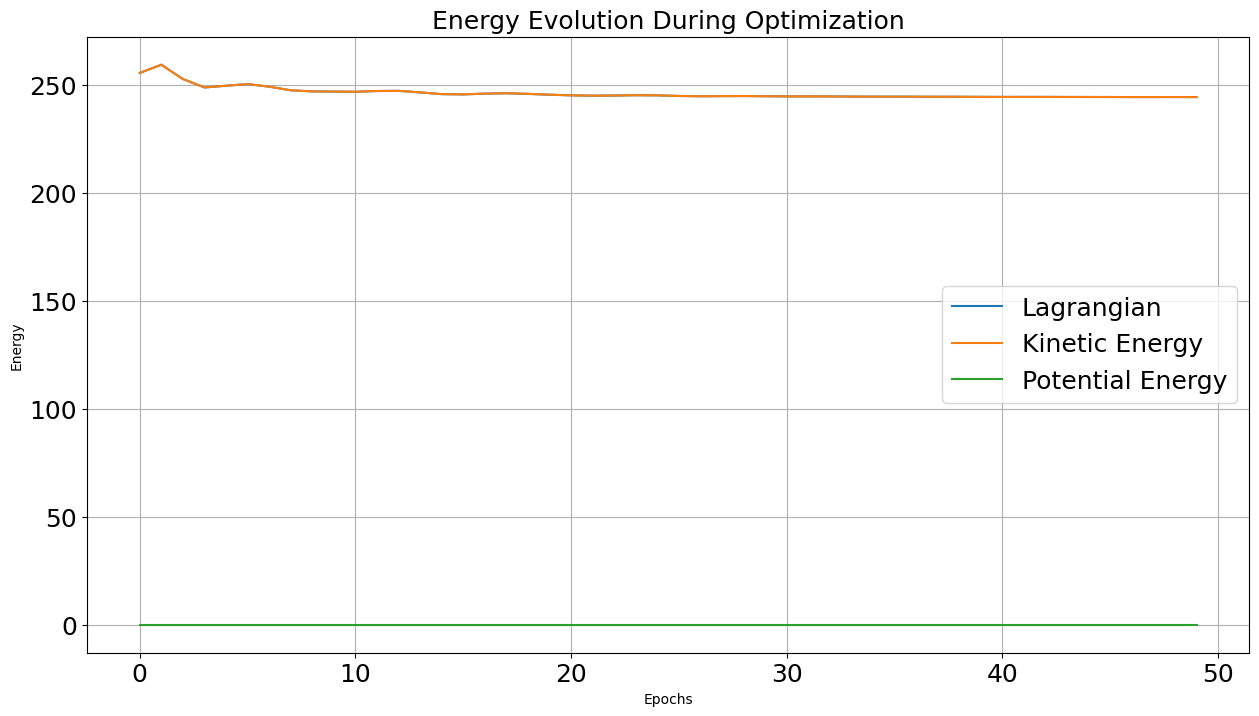

In [21]:
fig = plt.figure(figsize=(15, 8))
plt.plot(history.lagrangian, label='Lagrangian')
plt.plot(history.kinetic, label='Kinetic Energy')
plt.plot(history.potential, label='Potential Energy')
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title('Energy Evolution During Optimization', fontsize=18)
plt.grid()
plt.show()

In [22]:

time_trajectory = jnp.linspace(0, 1, 20)
num_samples = 2000
sample_trajectory_opt = gen_sample_trajectory(
    spline_state=optimized_state,
    vf=vf,
    key=subkey,
    num_samples=num_samples,
    t_traj=time_trajectory,
    solver=MidpointSolver,
)

sample_trajectory_no_opt = gen_sample_trajectory(
    spline_state=spline,
    vf=vf,
    key=subkey,
    num_samples=num_samples,
    t_traj=time_trajectory,
    solver=MidpointSolver,
)


key,subkey = jrandom.split(key)




In [23]:
# Compute lagrangians

lagrangian_opt = lagrangian(samples_path=sample_trajectory_opt,
                            times_path=time_trajectory,
                            problem_config=config_problem)
lagrangian_no_opt = lagrangian(samples_path=sample_trajectory_no_opt,
                               times_path=time_trajectory,
                               problem_config=config_problem)

print(f"Lagrangian (Optimized): {lagrangian_opt}")
print(f"Lagrangian (No Optimization): {lagrangian_no_opt}")

Lagrangian (Optimized): (Array(244.65756, dtype=float32), Array(244.65756, dtype=float32), Array(0., dtype=float32))
Lagrangian (No Optimization): (Array(255.73708, dtype=float32), Array(255.73708, dtype=float32), Array(0., dtype=float32))


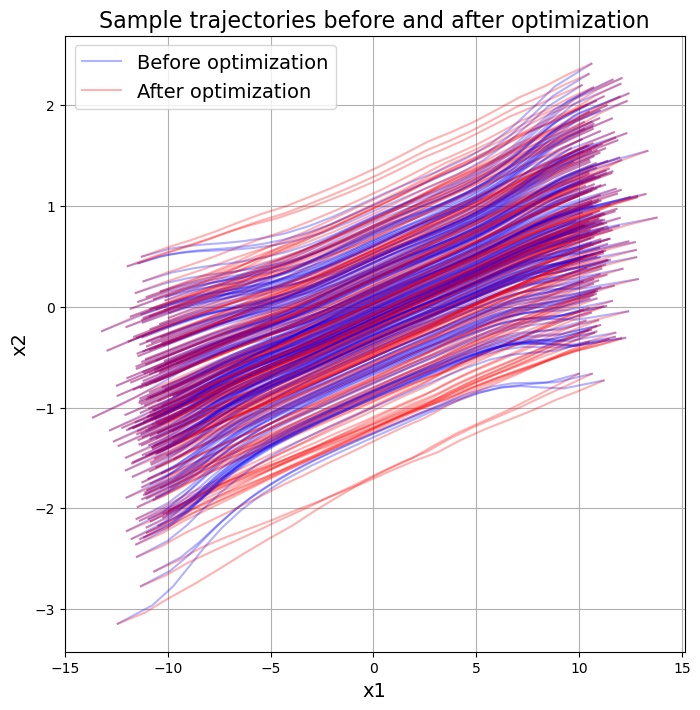

In [24]:
fig = plt.figure(figsize=(8, 8))

plt.plot(sample_trajectory_no_opt[0,:,0],sample_trajectory_no_opt[0,:,1],'b-',label='Before optimization',alpha=0.3)
plt.plot(sample_trajectory_opt[0,:,0],sample_trajectory_opt[0,:,1],'r-',label='After optimization',alpha=0.3)

for i in range(1,len(sample_trajectory_no_opt),10):
    plt.plot(sample_trajectory_no_opt[i,:,0],sample_trajectory_no_opt[i,:,1],'b-',alpha=0.3)
    plt.plot(sample_trajectory_opt[i,:,0],sample_trajectory_opt[i,:,1],'r-',alpha=0.3)



plt.title('Sample trajectories before and after optimization',fontsize=16)
plt.xlabel('x1',fontsize=14)
plt.ylabel('x2',fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

/tmp/ipykernel_1201015/1871623583.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


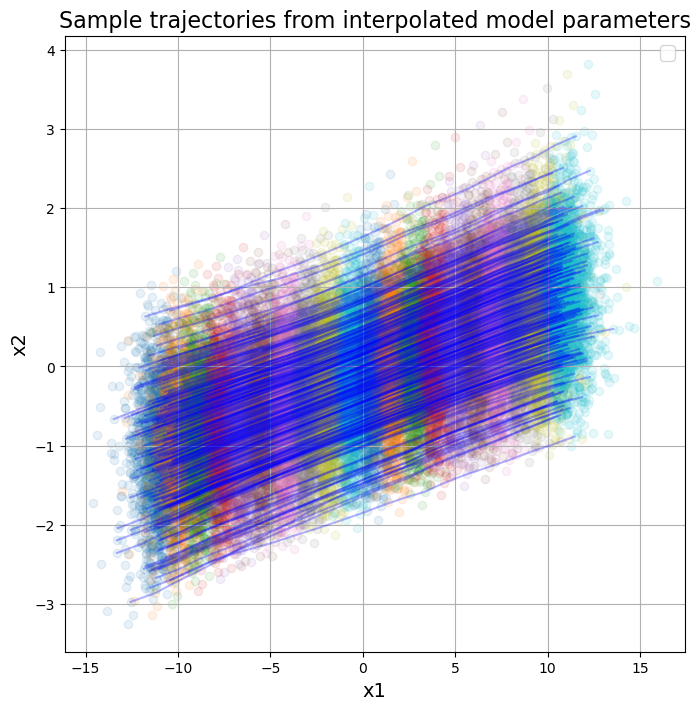

In [25]:
fig = plt.figure(figsize=(8, 8))    

for i in range(len(time_trajectory)):
    plt.scatter(sample_trajectory_opt[:,i,0],sample_trajectory_opt[:,i,1],alpha=0.1)

for i in range(0,len(sample_trajectory_opt),10):
    plt.plot(sample_trajectory_opt[i,:,0],sample_trajectory_opt[i,:,1],'b-',alpha=0.3)



plt.title('Sample trajectories from interpolated model parameters',fontsize=16)
plt.legend(fontsize=14)
plt.xlabel('x1',fontsize=14)
plt.ylabel('x2',fontsize=14)
plt.grid()
plt.show()